Welcome! This is a tutorial about RASpy (Reaction Activity Scores in Python). 
In this notebook, we will show how to perform cluster analysis on the RAS matrix using the Scanpy toolkits.

In [1]:
import sys
sys.path.insert(1, '../raspy/')

## Load the data

Load the ras matrix (h5ad format), previously compute on notebook "Ras computation"

In [2]:
import scanpy as sc
ras_adata=sc.read_h5ad("../datasets/E-GEOD-86618_ras_adata")
ras_adata

AnnData object with n_obs × n_vars = 540 × 5566
    obs: 'countmatrix_Sample Characteristic[organism]', 'countmatrix_Sample Characteristic Ontology Term[organism]', 'countmatrix_Sample Characteristic[individual]', 'countmatrix_Sample Characteristic Ontology Term[individual]', 'countmatrix_Sample Characteristic[organism part]', 'countmatrix_Sample Characteristic Ontology Term[organism part]', 'countmatrix_Sample Characteristic[cell type]', 'countmatrix_Sample Characteristic Ontology Term[cell type]', 'countmatrix_Sample Characteristic[facs marker]', 'countmatrix_Sample Characteristic Ontology Term[facs marker]', 'countmatrix_Sample Characteristic[disease]', 'countmatrix_Sample Characteristic Ontology Term[disease]', 'countmatrix_Factor Value[single cell identifier]', 'countmatrix_Factor Value Ontology Term[single cell identifier]', 'countmatrix_Factor Value[disease]', 'countmatrix_Factor Value Ontology Term[disease]'
    var: 'common_gprs', 'compartments', 'GPR rule'

## Pre-processing of the RAS matrix

Drop duplicates reaction (for example, toe reaction having the same GPR

In [3]:
reactions=list(ras_adata.to_df().T.drop_duplicates().index)
ras_adata=ras_adata[:,reactions]
ras_adata

View of AnnData object with n_obs × n_vars = 540 × 1324
    obs: 'countmatrix_Sample Characteristic[organism]', 'countmatrix_Sample Characteristic Ontology Term[organism]', 'countmatrix_Sample Characteristic[individual]', 'countmatrix_Sample Characteristic Ontology Term[individual]', 'countmatrix_Sample Characteristic[organism part]', 'countmatrix_Sample Characteristic Ontology Term[organism part]', 'countmatrix_Sample Characteristic[cell type]', 'countmatrix_Sample Characteristic Ontology Term[cell type]', 'countmatrix_Sample Characteristic[facs marker]', 'countmatrix_Sample Characteristic Ontology Term[facs marker]', 'countmatrix_Sample Characteristic[disease]', 'countmatrix_Sample Characteristic Ontology Term[disease]', 'countmatrix_Factor Value[single cell identifier]', 'countmatrix_Factor Value Ontology Term[single cell identifier]', 'countmatrix_Factor Value[disease]', 'countmatrix_Factor Value Ontology Term[disease]'
    var: 'common_gprs', 'compartments', 'GPR rule'

Normalize the data

In [4]:
sc.pp.normalize_total(ras_adata, target_sum=1e4)

C:\Users\bruno\anaconda3\envs\progettoRas\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data

In [5]:
sc.pp.log1p(ras_adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use 

In [6]:
ras_adata.raw = ras_adata

Scale each reaction score to unit variance. Clip values exceeding standard deviation 10.

In [7]:
sc.pp.scale(ras_adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA)

In [8]:
sc.tl.pca(ras_adata, svd_solver='arpack')

Make a scatter plot in the PCA coordinates, showing some differences

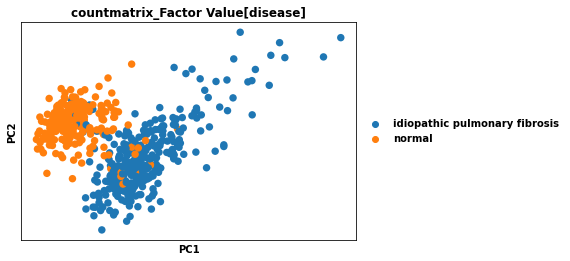

In [9]:
from matplotlib.colors import ListedColormap
sc.pl.pca(ras_adata, color=['countmatrix_Factor Value[disease]'])

Let us inspect the contribution of single PCs to the total variance in the data. 

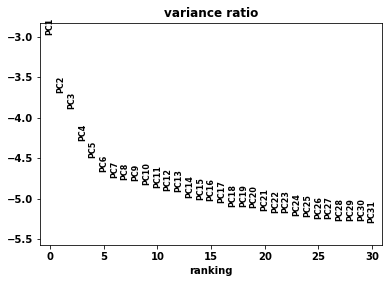

In [10]:
sc.pl.pca_variance_ratio(ras_adata, log=True)

## Compute the clustering (default cluster parameters)

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 

In [11]:
sc.pp.neighbors(ras_adata)

Cluster the cells using the Leiden algorithm

In [12]:
sc.tl.leiden(ras_adata)

Embed the graph in two dimensions using UMAP

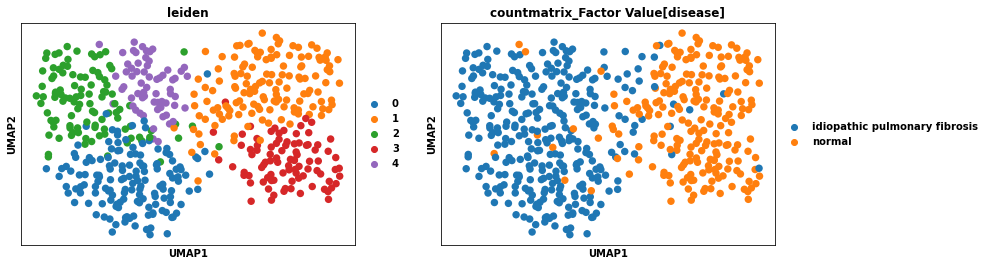

In [13]:
sc.tl.umap(ras_adata)
sc.pl.umap(ras_adata,  color=['leiden','countmatrix_Factor Value[disease]'])

## Find best clustering

In [14]:
from utils import find_bh

In [15]:
resolutions=[0.25,0.5,0.75,1,1.25,1.5]
n_pcs=[5,10,15,20]
n_neighbors=[5,10,15,20]

In [16]:
df=find_bh(ras_adata,resolutions=resolutions,
    n_pcs=n_pcs,
    n_neighbors=n_neighbors,
    names_of_groud_truth=[])
df

,res,pcs_values,neigh_values,num_cluster,cluster_values_sil
0,0.25,5,5,4,0.175111
1,0.50,5,5,8,0.160437
2,0.75,5,5,11,0.128291
3,1.00,5,5,14,0.130888
4,1.25,5,5,20,0.113786
...,...,...,...,...,...
91,0.50,20,20,2,0.140879
92,0.75,20,20,4,0.123713
93,1.00,20,20,5,0.061805
94,1.25,20,20,7,0.050216


In [17]:
obj_fun="cluster_values_sil"
index=df[obj_fun].argmax()
res,n_pc,n_neighbor=df.iloc[index][["res","pcs_values","neigh_values"]].values
res,n_pc,n_neighbor
df[obj_fun].max()

0.2980479896068573

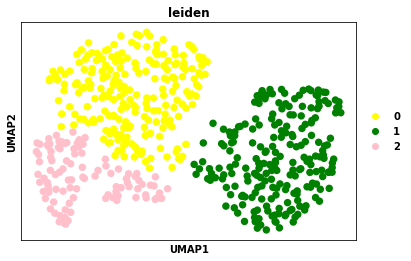

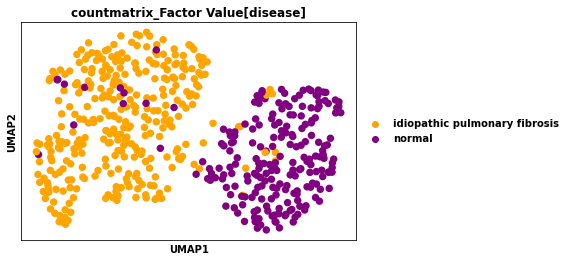

In [18]:
sc.pp.neighbors(ras_adata, n_neighbors=int(n_neighbor), n_pcs=int(n_pc))
sc.tl.leiden(ras_adata,resolution=res)
sc.tl.umap(ras_adata)
sc.pl.umap(ras_adata, color=['leiden'],
          palette={"0":"yellow",
                   "1":"green",
                   "2":"pink"})
sc.pl.umap(ras_adata, color=['countmatrix_Factor Value[disease]'],
           palette={"normal":"purple",
                    "idiopathic pulmonary fibrosis":"orange"})

## Finding marker reactions

Let us compute a ranking for the highly differential RAS in each cluster.

In [19]:
from utils import rank_reactions_groups
rank_reactions_groups(ras_adata, 'leiden', method='t-test')

Show the 5 top ranked RAS per cluster.

In [20]:
import pandas as pd
df_markers=pd.DataFrame(ras_adata.uns['rank_genes_groups']['names']).head(5)
df_markers

,0,1,2
0,PYK,SPODMm,NMNATm
1,PYK6,FACOAL1812_1,NMNAT
2,4HALDD,PIt7,NNATr
3,34DHXMANDACOX,ALAATB0tc,HMR_8397
4,MACOXO,ILEt4,ACCOAC


Convert the dataframe in a list

In [21]:
df_marker_list=df_markers.T.values.flatten()
df_marker_list

array(['PYK', 'PYK6', '4HALDD', '34DHXMANDACOX', 'MACOXO', 'SPODMm',
       'FACOAL1812_1', 'PIt7', 'ALAATB0tc', 'ILEt4', 'NMNATm', 'NMNAT',
       'NNATr', 'HMR_8397', 'ACCOAC'], dtype=object)

Makes a dot plot of the expression values of ras.

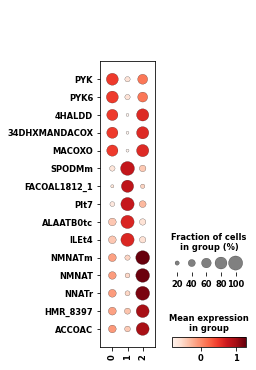

In [22]:
sc.pl.dotplot(ras_adata, df_marker_list, groupby='leiden',
              use_raw=False,swap_axes=True);

Save the results 

In [23]:
ras_adata.write("../datasets/E-GEOD-86618ras_adata_clustering")